# Validation Kernel

We should have done this as our first step, but better late than never. This simple kernel demonstrates how to run local feature validation.

In [1]:
import pandas as pd
import numpy as np
from time import time
import datetime
import lightgbm as lgb
import gc, warnings, json
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from scipy import interp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA

In [2]:
traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')
testtr  = pd.read_csv('input/test_transaction.csv.zip')
testid  = pd.read_csv('input/test_identity.csv.zip')

In [3]:
# For each categorical variable, we'd like to experiment with
# the count of appearances within that day's hour
# This will only work if the distributions (counts) are similar in train + test

START_DATE     = '2017-11-01'
startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
traintr['tdt']    = traintr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['thour']  = traintr.tdt.dt.hour
traintr['tmonth'] = (traintr.tdt.dt.year-2017) * 12 + traintr.tdt.dt.month
traintr['tweek'] = 52 * (traintr.tdt.dt.year-2017) + traintr.tdt.dt.weekofyear
traintr['tdoy'] = 365 * (traintr.tdt.dt.year-2017) + traintr.tdt.dt.dayofyear
traintr.tdoy -= traintr.tdoy.min() # 0-offset

testtr['tdt']    = testtr['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['thour']  = testtr.tdt.dt.hour
testtr['tmonth'] = (testtr.tdt.dt.year-2017) * 12 + testtr.tdt.dt.month
testtr['tweek'] = 52 * (testtr.tdt.dt.year-2017) + testtr.tdt.dt.weekofyear
testtr['tdoy'] = 365 * (testtr.tdt.dt.year-2017) + testtr.tdt.dt.dayofyear
testtr.tdoy -= traintr.tdoy.min() # 0-offset

traintr.tdt.min()

Timestamp('2017-11-02 00:00:00')

In [4]:
traintr.groupby('tmonth').size()

tmonth
11    130968
12     92770
13     96196
14     90667
15     87512
16     86934
17      5493
dtype: int64

In [5]:
traintr.tdoy.min(),traintr.tdoy.max()

(0, 181)

# Feature Evaluation Pipeline

In [6]:
SEED = 2**8+1

# TODO: Optimize
lgb_params = {
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'n_jobs':-1,
    'learning_rate':0.01,
    'num_leaves': 2**6, # 5-8
    'max_depth':-1,
    'tree_learner':'serial',
    'colsample_bytree': 0.7, ######################
    'subsample':0.7, ####################    
    
    'subsample_freq':1,

    'max_bin':255,
    'verbose':-1,
    'seed': SEED,
    'feature_fraction_seed': SEED + 2,
    'bagging_seed': SEED + 3,
    'drop_seed': SEED + 4,
    'data_random_seed': SEED + 5,
} 

In [7]:
def display_report(report):
    print('{} Folds Used'.format(len(report['folds'])))
    print('{} Neg DownSample Frac with {} Seed'.format(report['downsample_frac'], report['downsample_seed']))
    print('{} AVG AUC, {} STD'.format(np.round(report['avg_auc'],3), np.round(report['std_auc'],3)))
    print('{} AVG Train AUC, {} STD'.format(np.round(report['avg_train_auc'],3), np.round(report['std_train_auc'],3)))
    print(np.abs(np.round(report['avg_train_auc'] - report['avg_auc'],3)), 'Train-Val AUC Drift')
    print('{} AVG Rounds, {} STD'.format(report['avg_iterations'], report['std_iterations']), end='\n\n')

    features = pd.DataFrame({
        'feature': list(report['cvs'].keys()),
        'adversarial': list(report['cvs'].values()),
        'perm_import': list(report['avg_permutation_importance'].values()),
        'perm_import_std': list(report['std_permutation_importance'].values()),
    })
    #if do_cvs
    features.sort_values(['perm_import','adversarial'], ascending=False, inplace=True)
    
    sns_df = pd.DataFrame({
        'feature' : sum([list(fold['permutation_importance'].keys()) for fold in report['folds']], []),
        'perm_import': sum([list(fold['permutation_importance'].values()) for fold in report['folds']], []),
    })
    sns_df.sort_values(['feature','perm_import'], ascending=False, inplace=True)
    
    print(report['params'])
    return features, sns_df

def compare_reports(report1, report2):
    pass

In [8]:
def run_evaluation(data, features, params, do_cvs=True, cvs_threshold=0.1, do_pi=True, downsample_seed=None, downsample_frac=0.2, save_file_path=None, calc_sub=False):
    # NOTE: data should contain, at minimal, all train + test samples,
    # along with the isFraud column, for separation and scoring purposes.
    gc.collect()
    
    # Run evaluation and store results in a report
    # Steps:
    # 1) [x] Negative Downsample non-frauds
    # 2) [x] Run adversarial validation on features + record scores
    # 3) [x] Train on 50% overlapping folds on the trainset
    # 3b) [x] Perform permutation importance (soon to be drop importance) each fold
    # 4) [x] Aggregate and save results
    
    report = {
        'params': params,
        'downsample_seed': downsample_seed,
        'downsample_frac': downsample_frac,
        'cvs': {},
        'folds': [],
        'avg_permutation_importance': {},
        'std_permutation_importance': {},
    }
    
    ######################
    print('\n# 1) [x] Negative Downsample (non-frauds)')
    if downsample_seed is None:
        selection = data.copy()
    else:
        np.random.seed(downsample_seed)
        normies = data[data.isFraud==0].index.values
        normies = np.random.choice(
            normies,
            int(data.shape[0]*downsample_frac),
            replace=False
        )
        selection = data[data.index.isin(
            # All fruds and a number of normies
            np.concatenate([normies, data[data.isFraud==1].index.values])
        )].copy()
        del normies
    print(selection.shape[0], 'total train samples!')
    
    if selection.shape[0] > data.isFraud.isna().sum():
        # If we have more train samples than test samples, use all test samples
        selection_test = data[data.isFraud.isna()]
    else:
        # Use a balanced set of test samples 
        selection_test = np.random.choice(
            data[data.isFraud.isna()].index.values,
            selection.shape[0],
            replace=False
        )
        selection_test = data[data.index.isin(selection_test)]

    ######################
    if do_cvs:
        print('\n# 2) [x] Run adversarial validation (CVS) on features + record scores')
        # Build CVS dataset
        cvsdata = selection.append(selection_test, sort=False)
        cvsdata.reset_index(inplace=True)
        cvsdata['which_set'] = (np.arange(cvsdata.shape[0]) >= selection.shape[0]).astype(np.uint8)
        cvsdata = cvsdata.sample(frac=1).reset_index(drop=True) # Shuffle the thing
        trn_cvs = cvsdata.index < (cvsdata.shape[0] // 2)
        trn = cvsdata[trn_cvs]
        val = cvsdata[~trn_cvs]
        del trn_cvs, selection_test; gc.collect()
        for col in features:
            trn_lgb = lgb.Dataset(trn[[col]], label=trn.which_set)
            val_lgb = lgb.Dataset(val[[col]], label=val.which_set)
            clf = lgb.train(
                params,
                trn_lgb,
                valid_sets = [trn_lgb, val_lgb],
                verbose_eval = 200,
                early_stopping_rounds = 25,
                num_boost_round = 80000,
            )
            report['cvs'][col] = clf.best_score['valid_1']['auc'] - 0.5 # 0.5 = 0, best score
            del clf, trn_lgb, val_lgb; gc.collect()
        del cvsdata; gc.collect()
    
    ######################
    sub = []
    print('\n#3) [x] Train on 50% overlapping folds on the trainset')
    for fold_, i in enumerate(range(0,57,14)):
        gc.collect()
        fold = {
            'fold_num': fold_,
            'trn_range': [i,i+90],
            'val_range': [i+90+15,i+90+15+20],
        }
        print('\nFold', fold_+1, '— Train', fold['trn_range'], '— Test', fold['val_range'])
        
        trn = selection[selection.tdoy.between(i, 90+i)]
        val = selection[selection.tdoy.between(90+i+15, 90+i+15+20)]
        trn_lgb = lgb.Dataset(trn[features], label=trn.isFraud)
        val_lgb = lgb.Dataset(val[features], label=val.isFraud)
        clf = lgb.train(
            params,
            trn_lgb,
            valid_sets = [trn_lgb, val_lgb],
            verbose_eval = 200,
            early_stopping_rounds = 25,
            num_boost_round = 80000,
            #categorical_feature=[]
        )
        baseline = clf.best_score['valid_1']['auc']
        fold['auc'] = baseline
        fold['train_auc'] = clf.best_score['training']['auc']
        fold['iterations'] = clf.best_iteration
        print('baseline - ', baseline)
        
        if calc_sub:
            print('Predicting Subm')
            sub.append(clf.predict(data[data.isFraud.isna()][features]))
        
        ######################
        # TODO: Repalce with Drop importance
        if do_pi:
            print('\n#3b) [x] Perform permutation importance (soon to be drop importance) each fold')
            del trn, trn_lgb; gc.collect()
            val = val.copy(); gc.collect()
            perm = {}
            for col in tqdm(features):
                if report['cvs'][col] > cvs_threshold:
                    # Don't waste time on whack features
                    perm[col] = np.nan
                    continue
                
                backup = val[col].values.copy()
                val[col] = np.random.permutation(val[col].values)

                y_true = clf.predict(val[features])
                perm[col] = baseline - roc_auc_score(val.isFraud, y_true)
                val[col] = backup
            fold['permutation_importance'] = perm
            del val, val_lgb; gc.collect()
        report['folds'].append(fold)
            
    
    ######################
    print('\n# 4) [x] Aggregate and save results')
    aucs = [fold['auc'] for fold in report['folds']]
    report['avg_auc'] = np.mean(aucs)
    report['std_auc'] = np.std(aucs)
    
    aucs = [fold['train_auc'] for fold in report['folds']]
    report['avg_train_auc'] = np.mean(aucs)
    report['std_train_auc'] = np.std(aucs)

    iterations = [fold['iterations'] for fold in report['folds']]
    report['avg_iterations'] = np.mean(iterations)
    report['std_iterations'] = np.std(iterations)

    if do_pi:
        for feature in features:
            pi = [fold['permutation_importance'][feature] for fold in report['folds']]
            report['avg_permutation_importance'][feature] = np.nanmean(pi)
            report['std_permutation_importance'][feature] = np.nanstd(pi)

    if save_file_path is not None:
        with open(save_file_path, 'w', encoding='utf-8') as f:
            json.dump(report, f, ensure_ascii=False, indent=4)
        
    gc.collect()
    return report, sub

# NA Imputation vs Baseline

In [9]:
# Merge train + test
gc.collect()
data = traintr.append(testtr, sort=False)
data.reset_index(inplace=True, drop=True)

In [ ]:
# NA Imputation actually decreased score from baseline. Maybe I did it wrong?

In [ ]:
# features = [f for f in data.columns if f not in ['isFraud','TransactionID','TransactionDT','tdt','thour','tmonth','tweek','tdoy']]
# print(len(features), 'features')

# # LE:
# for col in features:
#     if data[col].dtype!='O': continue
#     print('Found str', col, '... encoding!')
#     mapper = {key:val for val,key in enumerate(data[~data[col].isna()][col].unique())}
#     data[col] = data[col].map(mapper)
    
# results, _ = run_evaluation(
#     data,
#     features,
#     lgb_params,
#     downsample_seed=1773+1,
#     downsample_frac=0.2,
#     do_cvs=False,
#     do_pi=False,
#     save_file_path='./uthman_baseline_0.json',
#     calc_sub=False,
# )

In [ ]:
# threshold = 5
# for col in ['card3']: #email, cards
#     if col[0]=='M': continue
        
#     num_na = data[col].isna().sum()
#     if num_na==0: continue
        
#     temp = data.groupby(['card1',col]).size().reset_index()
#     temp.sort_values(['card1',col], ascending=False, inplace=True)
#     temp = temp[temp[0] >= threshold] # {card1, col_val} pair occurs at least...
#     del temp[0]
#     temp.drop_duplicates(inplace=True)
#     pot_nas_cnt = temp.shape[0]
#     temp = temp.merge(data[['ProductCD','card1',col]].drop_duplicates(), how='left', on=['card1',col])
    
#     nas_cnt = data[col].isna().sum()
#     for pcd in data.ProductCD.unique():
#         # The match has to occur on ProductCD as well...
#         mapping = {card1:col_val for card1,col_val in temp[temp.ProductCD==pcd][['card1',col]].values}
#         nas = (data.ProductCD==pcd) & data[col].isna()
#         data.loc[nas, col] = data[nas].card1.map(mapping)
    
#     print(col, nas_cnt, 'NAs.', nas_cnt - data[col].isna().sum(), 'filled from', pot_nas_cnt, 'pairings.')

In [ ]:
# features = [f for f in data.columns if f not in ['isFraud','TransactionID','TransactionDT','tdt','thour','tmonth','tweek','tdoy']]
# print(len(features), 'features')

# # LE:
# for col in features:
#     if data[col].dtype!='O': continue
#     print('Found str', col, '... encoding!')
#     mapper = {key:val for val,key in enumerate(data[~data[col].isna()][col].unique())}
#     data[col] = data[col].map(mapper)
    
# results, _ = run_evaluation(
#     data,
#     features,
#     lgb_params,
#     downsample_seed=1773+1,
#     downsample_frac=0.2,
#     do_cvs=False,
#     do_pi=False,
#     save_file_path='./uthman_nanfills_threshold_3.json',
#     calc_sub=False,
# )

In [ ]:
# Basically, nan fill strategy isn't looking so good thus far

# Deep Feature Engineering

In [10]:
sorted_best_vsets = [
    # 20663
    ['V201','V180','V169','V209','V199','V258','V234','V331','V283','V314','V296','V303','V294','V308','V307','V292'],
    ['V200','V171','V203','V190','V264','V257','V329','V323','V154','V282','V315','V301','V304','V317','V280','V310','V291','V123'],
    ['V170','V189','V204','V178','V187','V265','V218','V246','V330','V327','V333','V140','V281','V313','V289','V300','V302','V318','V306','V285','V290','V125'],
    ['V188','V195','V202','V213','V168','V212','V176','V219','V229','V339','V326','V332','V153','V288','V295','V279','V312','V321','V320','V305','V124'],
    ['V194','V198','V167','V179','V186','V274','V263','V230','V338','V325','V324','V157','V316','V287','V298','V102','V128','V127','V116','V45','V12','V23'],
    ['V184','V197','V185','V175','V211','V192','V232','V217','V243','V328','V334','V322','V156','V293','V284','V299','V103','V133','V126','V97','V130','V96','V114','V36','V13','V24'],
    ['V174','V210','V177','V193','V215','V275','V244','V337','V336','V139','V309','V319','V134','V95','V99','V115','V44','V20','V26','V14'],
    ['V208','V191','V182','V233','V228','V335','V138','V158','V297','V311','V132','V131','V112','V35','V19','V25','V91','V87','V56'],
    ['V196','V231','V242','V248','V162','V149','V286','V101','V111','V113','V136','V52','V38','V90','V86','V54','V55'],
    ['V183', 'V173', 'V172', 'V207', 'V273', 'V249', 'V259', 'V220', 'V271', 'V141', 'V155', 'V151', 'V105', 'V110', 'V51', 'V37','V76', 'V78', 'V53', 'V65'],
    
    
    #20659
    ['V181', 'V216', 'V206', 'V205', 'V261', 'V247', 'V222', 'V142','V147', 'V148', 'V150', 'V106', 'V109', 'V40', 'V47', 'V75', 'V77','V62'],
    ['V214', 'V262', 'V236', 'V254', 'V221', 'V163', 'V146', 'V164','V152', 'V137', 'V100', 'V108', 'V118', 'V39', 'V46', 'V83', 'V88','V67'],
    ['V260', 'V277', 'V253', 'V245', 'V161', 'V160', 'V143', 'V145','V129', 'V135', 'V117', 'V119', 'V121', 'V50', 'V41', 'V82', 'V61','V66'],
    
    #20656
    ['V237', 'V252', 'V240', 'V251', 'V159', 'V165', 'V144', 'V98','V104', 'V122', 'V43', 'V34', 'V70', 'V3'],
    ['V278', 'V225', 'V226', 'V224', 'V241', 'V250', 'V166', 'V120','V42', 'V74', 'V69', 'V9'],
    ['V235', 'V223', 'V267', 'V239', 'V256', 'V107', 'V33', 'V60','V10', 'V4', 'V7'],
    
    #17756
    ['V276', 'V269', 'V266', 'V268', 'V238', 'V255', 'V227', 'V49','V15', 'V31', 'V17', 'V29', 'V30', 'V94', 'V93', 'V73', 'V72','V59', 'V11', 'V2'],
    
    #14917
    ['V272', 'V48', 'V16', 'V32', 'V18', 'V79', 'V92', 'V80', 'V58','V71', 'V64', 'V5', 'V6'],
    
    #14606
    ['V270', 'V21', 'V22', 'V81', 'V57', 'V63', 'V8'],
    
    #13416
    ['V84', 'V85', 'V1'],
]

for i,fset in enumerate(sorted_best_vsets):
    if i==4: break #everything else sux
    data['vset{}_gt0'.format(i+1)] = (data[fset]>0).sum(axis=1)

In [11]:
cat_cols = [
    'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
]

cont_cols = [
    # TransactionID, TransactionDT
    'TransactionAmt', 'dist1', 'dist2',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'C11', 'C12', 'C13', 'C14',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
    'D11', 'D12', 'D13', 'D14', 'D15',
] + ['V'+str(v) for v in range(1,340)]

In [12]:
cont_cols_good_auc = [
    'TransactionAmt', 'dist1', 'dist2',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
] + sorted_best_vsets[0] + sorted_best_vsets[1] + sorted_best_vsets[2] + sorted_best_vsets[3] + sorted_best_vsets[4]
len(cont_cols_good_auc)

131

In [14]:
col_meanstd = 'C1,C2,C5,C6,C8,C9,C14,D8,D12,V170,V187,V258,V283,V308,V309,V310,V312,V317' #MEANSTD
col_vcs = 'C13,TransactionAmt' #VCS

for col in col_meanstd.split(','):
    # Feature: Self Standardization:
    data[col+'_meanstd'] = (data[col] - data[col].mean()) / data[col].std()
    
for col in col_vcs.split(','):
    # Feature: VCs to look for irregular values
    # In this case, think of it more like a density over the bin range
    temp = (data[col] - data[col].mean()) / data[col].std()
    
    nmin = np.nanmin(temp)
    nmax = np.nanmax(temp)
    num_bins = min(32, (nmax-nmin) / (lgb_params['max_bin'] / 8))
    bins = np.arange(nmin,nmax,(nmax-nmin)/num_bins)
    data[col+'_vcs'] = np.digitize(temp, bins) - 1 # starts @bin=1
    
col_vcs = 'R_emaildomain,P_emaildomain,M4,M5'
for col in col_vcs.split(','):
    # Feature: VCs for categoricals
    data[col+'_vcs'] = data[col].map(data[col].value_counts())

In [15]:
for col in 'V102,V303,V282,V160,V329,V258,R_emaildomain,P_emaildomain,M4,M5,D2,D4,D11,D15'.split(','):
    # low cvs and na-ration between train+test, good auc as well. generally
    data[col+'isna'] = data[col].isna()

In [ ]:
clipper = 77 #11-weeks
for d in 'D1,D10,D15'.split(','):
    #traintr[d+'_mfix'] = traintr[d] - traintr.tdtd
    #testtr[d+'_mfix'] = testtr[d] - testtr.tdtd
    data[d+'_clip'] = data[d].clip(0,77) # 11-weeks

# Deeper FE

In [16]:
agg_period = '7d'
stringy = lambda x: x.astype(str) + ';'

cat_cols_hi_card = [

    # card1 = UID
    # card2 = issuer bank name
    # card3 = country issued in
    # card4 = visa/master = card name
    # card5 = ?sourcesoftware?
    # card6 = creditdebit = card category of transaction
    
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
    'card1', 'card2', 'card3', 'card5', 
    'card12', 'card123', 'card1235' # TODO: Build these out!
]

data['card12'] = stringy(data.card1) + stringy(data.card2)
data['card123'] = stringy(data.card12) + stringy(data.card3)
data['card1235'] = stringy(data.card123) + stringy(data.card5)

cont_cols_good_auc = [
    'TransactionAmt', 'dist1', 'dist2',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',
] + sorted_best_vsets[0] + sorted_best_vsets[1] + sorted_best_vsets[2] + sorted_best_vsets[3] + sorted_best_vsets[4]

In [ ]:
# NOTE: Here is a shortened list.
# If you do not run the following two lines, well... I hope you have > 100GB Ram'

cont_cols_good_auc = 'V283,V258,C5,D8'.split(',')
cat_cols_hi_card = 'card1,card2,card5,addr2'.split(',')

In [17]:

# TODO: Try these again w/o ProductCD grouping...
for cat in cat_cols_hi_card:
    # Feature: VCs to look for irregular values:
    data[cat+'_vcs'] = data[cat].map(
        data[cat].value_counts().to_dict()
    )
    
    if cat=='ProductCD':
        continue
        
    # Cat-Cont interactions
    grp_ProductCD_cat = data.groupby(['ProductCD', cat]).rolling(on='tdt', window=agg_period)
    for cont in tqdm(cont_cols_good_auc):
        gc.collect()
        temp = grp_ProductCD_cat[cont].agg(['mean','std']).reset_index()
        
        # Due to time and memory constraints, we use the first value found per second
        new_colA = '{}_pcd_grp__{}_{}_mean'.format(cat, cont, agg_period)
        new_colB = '{}_pcd_grp__{}_{}_std'.format(cat, cont, agg_period)
        temp.drop_duplicates(['ProductCD', cat, 'tdt'], inplace=True)
        temp.rename(columns={
            'mean':new_colA,
            'std':new_colB,
        }, inplace=True)
        
        data = data.merge(temp, how='left', on=['ProductCD', cat, 'tdt'])
        
        # And normalize:
        data[cont + '_remove_' + new_colA] = data[cont] - data[new_colA]

100%|██████████| 4/4 [00:24<00:00,  7.57s/it]


# EDA

In [ ]:
# feats = []
# for cat in cat_cols:
#     cnt_na = data[cat].isna().sum()
#     cnt_fraud = (data[~data[cat].isna()].isFraud==1).sum()
#     results, _ = run_evaluation(
#         data,
#         [cat],
#         lgb_params,
#         downsample_seed=1773+1,
#         downsample_frac=0.2,
#         do_cvs=True,
#         do_pi=False,
#         calc_sub=False,
#     )
#     feats.append([
#         cat,
#         cnt_na,
#         cnt_na/data.shape[0],
#         cnt_fraud,
#         results['avg_auc'],
#         results['std_auc'],
#         results['cvs'][cat],
#     ])

# z = pd.DataFrame(feats, columns=['col','nancnt','nanr','fraudcnt','auc','aucstd','cvs'])
# z['fraudcnt_ratio'] = z.fraudcnt / (data.shape[0]-z.nancnt)
# z.sort_values('fraudcnt_ratio')

In [ ]:
# REmail domains w/ high fraud/non-nan ratio counts:
#     'netzero.net',
#     'protonmail.com',
#     'mail.com',
#     outlook.es, icould.com, outlook.com, gmail.com,

# More FE:

In [18]:
# Build out additional ID columns

# Card Stuff
# card1 = UID
# card2 = issuer bank name
# card3 = country issued in
# card4 = visa/master = card name
# card5 = ?sourcesoftware?
# card6 = creditdebit = card category of transaction
#data['card12'] = stringy(data.card1) + stringy(data.card2)
#data['card1235'] = stringy(data.card12) + stringy(data.card3) + stringy(data.card5)
data['card1235addr1'] = stringy(data.card1235) + stringy(data.addr1)
data['card34'] = stringy(data.card3) + stringy(data.card4)

In [19]:
# FE Sole columns
data['dist'] = data.dist1
data.loc[~data.dist2.isna(), 'dist'] = data[~data.dist2.isna()].dist2

data['TransactionAmtCents'] = data.TransactionAmt - np.floor(data.TransactionAmt)

In [20]:
# FE Email Stuff
country_map = {
    'com':'us', 'net':'us', 'edu':'us', 'gmail':'us', 
    'mx': 'mx', 'es':'es', 'de':'de', 'fr':'fr',
    'uk':'uk', 'jp':'jp'
}
domain = lambda x: x.split('.')[0]
pemail_country = lambda x: x.split('.')[-1]
data['pemail_domain']  = data.P_emaildomain.astype(str).apply(domain)
data['pemail_ext']     = data.P_emaildomain.astype(str).apply(pemail_country).map(country_map)
data['remail_domain']  = data.R_emaildomain.astype(str).apply(domain)
data['remail_ext']     = data.R_emaildomain.astype(str).apply(pemail_country).map(country_map)
data['p_and_r_email']  = data.P_emaildomain.astype(str) + ' ' + data.R_emaildomain.astype(str)

In [22]:
data.columns.tolist()

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [23]:
# Features to Label Encode
# Makes join calculations more efficient.
label_encode = [
    'ProductCD',
    'card1',
    'card2',
    'card3',
    'card4',
    'card5',
    'card6',
    'addr1',
    'addr2',
    'dist1',
    'dist2',
    'P_emaildomain',
    'R_emaildomain',
    'M1',
    'M2',
    'M3',
    'M4',
    'M5',
    'M6',
    'M7',
    'M8',
    'M9',
    'card1235addr1',
    'card34',
    'pemail_domain',
    'pemail_ext',
    'remail_domain',
    'remail_ext',
    'p_and_r_email'
]

# LE:
for col in label_encode:
    if data[col].dtype!='O': continue

    # TODO whats happening to my nans?
    print('Found str', col, '... encoding!')
    mapper = {key:val for val,key in enumerate(data[~data[col].isna()][col].unique())}
    data[col] = data[col].map(mapper)

Found str ProductCD ... encoding!
Found str card4 ... encoding!
Found str card6 ... encoding!
Found str P_emaildomain ... encoding!
Found str R_emaildomain ... encoding!
Found str M1 ... encoding!
Found str M2 ... encoding!
Found str M3 ... encoding!
Found str M4 ... encoding!
Found str M5 ... encoding!
Found str M6 ... encoding!
Found str M7 ... encoding!
Found str M8 ... encoding!
Found str M9 ... encoding!
Found str card1235addr1 ... encoding!
Found str card34 ... encoding!
Found str pemail_domain ... encoding!
Found str pemail_ext ... encoding!
Found str remail_domain ... encoding!
Found str remail_ext ... encoding!
Found str p_and_r_email ... encoding!


In [ ]:
# TransactionAmt Feature Engineering
# Using ProductCD + UIDs
uids = [
    'card1','card2','card3','card4','card5','card6',
    'card12', 'card1235', 'card1235addr1', 'card34',
    'addr1',
]

for uid in tqdm(uids):
    new_colA = '{}_grp__TransactionAmt_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).TransactionAmt.mean().reset_index()
    means.rename(columns={'TransactionAmt':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.TransactionAmt - data[new_colA]


In [26]:
for uid in tqdm(uids):
    new_colA = '{}_grp__TransactionAmtCents_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).TransactionAmtCents.mean().reset_index()
    means.rename(columns={'TransactionAmtCents':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.TransactionAmtCents - data[new_colA]



100%|██████████| 11/11 [03:29<00:00, 19.43s/it]

In [27]:
# TransactionAmt Feature Engineering
# Using ProductCD + UIDs
for uid in tqdm(uids):
    new_colA = '{}_grp__dist_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).dist.mean().reset_index()
    means.rename(columns={'dist':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.dist - data[new_colA]


100%|██████████| 11/11 [03:42<00:00, 20.44s/it]

In [28]:
# One Offs
uids = [
    'p_and_r_email', # should be CE'd
]

for uid in tqdm(uids):
    new_colA = '{}_grp__D3_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).D3.mean().reset_index()
    means.rename(columns={'D3':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.D3 - data[new_colA]


100%|██████████| 1/1 [00:20<00:00, 20.61s/it]

In [29]:
# One Offs
uids = [
    'remail_domain',
]

for uid in tqdm(uids):
    new_colA = '{}_grp__D2_mean'.format(uid)
    new_colB = 'me2__' + new_colA
    means = data.groupby(['ProductCD',uid]).D2.mean().reset_index()
    means.rename(columns={'D2':new_colA}, inplace=True)
    data = data.merge(means, how='left', on=['ProductCD',uid])
    data[new_colB] = data.D2 - data[new_colA]
    


100%|██████████| 1/1 [00:20<00:00, 20.74s/it]

In [31]:
# Experiments
for d in [11,4,15,10]:
    # leave nans
    data['D{}_-_1'.format(d)] = data['D'+str(d)] - data.D1

In [32]:
for col in ['D11_-_1', 'D4_-_1', 'D15_-_1', 'D10_-_1']:
    data[col] = data[col].clip(-490,490)

In [33]:
# How many instances of the same d4 val happen within a 1day period?
# count number of Dx feature of same value for asme card/productid within timespan
what = data.groupby('card1').rolling(on='tdt', window='14d')['D4_-_1'].apply(lambda x: (x[-1]==x).sum(), raw=True).reset_index()
what = what.fillna(0)
what.drop_duplicates(['card1','tdt'], inplace=True)
what.rename(columns={'D4_-_1':'card1_grp__14dcnt_D4_-_1'}, inplace=True)
data = data.merge(what, how='left', on=['card1','tdt'])
del what; gc.collect()

In [35]:
pca = PCA(n_components=8, svd_solver='full', random_state=1)
dataC = pca.fit_transform(data[['C'+str(c) for c in [1,2,6,7,11,12,13,14]]].fillna(0))
for i in range(8): data['PCAC'+str(i+1)] = dataC[:,i].flatten()
del dataC

In [38]:
# card1-2 14d count
card12grp = data.groupby(['card12']).rolling(on='tdt', window='14d')

for col in tqdm('C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,PCAC1'.split(',')):
    what = card12grp[col].apply(lambda x: (x[-1]==x).sum(), raw=True).reset_index()
    what[col] = what[col].fillna(0)
    what.drop_duplicates(['card12','tdt'], inplace=True)
    what.rename(columns={col:'card12_grp__14dcnt_'+col}, inplace=True)
    data = data.merge(what, how='left', on=['card12','tdt'])
    
for col in ['PCAC1']:
    what = card12grp[col].apply(lambda x: (x[-1]==x).sum(), raw=True).reset_index()
    what[col] = what[col].fillna(0)
    what.drop_duplicates(['card12','tdt'], inplace=True)
    what.rename(columns={col:'card12_grp__7dcnt_'+col}, inplace=True)
    data = data.merge(what, how='left', on=['card12','tdt'])


100%|██████████| 15/15 [03:39<00:00, 13.52s/it]

In [41]:
data.shape

(1097231, 604)

# Persist Data

In [ ]:
# data.to_csv('./all_data_persist.csv', index=False)

In [ ]:
# data = pd.read_csv('./all_data_persist.csv')

# Do It

In [ ]:
# # gunes_tr = pd.read_csv('./gunes/train.csv.gz')
# # gunes_te = pd.read_csv('./gunes/test.csv.gz')

# gunes_tr = pd.read_csv('./gunes/gunes train.csv.gz')
# gunes_te = pd.read_csv('./gunes/gunes test.csv.gz')
# data = gunes_tr.append(gunes_te, sort=False)
# data.reset_index(drop=True, inplace=True)

# print(data.shape, 'gunes data shape')
# START_DATE     = '2017-11-01'
# startdate      = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
# data['tdt']    = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
# data['tdoy'] = 365 * (data.tdt.dt.year-2017) + data.tdt.dt.dayofyear
# data.tdoy -= data.tdoy.min() # 0-offset

# DATE_COLS = ['Minute', 'Hour', 'Day', 'DayOfWeek', 'DayOfYear', 'Week', 'Month', 'TransactionDate']
# ID_COLS = ['Card_ID1', 'Card_ID2', 'Card_ID3', 'Item_ID', 'Device_ID', 'PAccount_ID', 'RAccount_ID', 'PR_emaildomain', 'TransactionID']
# IDENTITIY_COLS = [col for col in gunes_tr.columns if col.startswith('id_') or 'id_' in col or 'Device' in col] + ['UserAgent', 'ParsingError', 'BrowserUpToDate']
# cols_to_drop = DATE_COLS + ID_COLS + IDENTITIY_COLS + ['V300','V309','V111', 'C3', 'V124','V106','V125','V315','V134','V102','V123','V316','V113',
#               'V136','V305','V110','V299','V289','V286','V318','V103','V304','V116','V29','V284','V293',
#               'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
#               'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120']
# data.drop([c for c in cols_to_drop if c in data.columns],axis=1,inplace=True)
# del gunes_tr, gunes_te; gc.collect()
# gc.collect()

# features = [f for f in data.columns if f not in cols_to_drop and f not in ['isFraud','TransactionDT','tdt','tdoy']]
# len(features)

In [ ]:
# # For Gunes:

# # Fill NA card data inasmuch as possible:
# fill_cols = ['card2','card3','card4','card5','card6']
# for col in fill_cols:
#     # We use both ProductCD+card1
#     card12 = data[~data.card2.isna()][['ProductCD','card1',col]].groupby(['ProductCD','card1',col]).size().reset_index()

#     card12.rename(columns={0:'card1_cnt'}, inplace=True)
#     card12_cnts = card12[card12.card1_cnt>=2].copy() # threshold of instances of pairings needed before we accept it
#     card12 = card12.groupby(['ProductCD','card1']).size().reset_index()
#     card12.rename(columns={0:col+'_cnt'}, inplace=True)
#     card12 = card12[card12[col+'_cnt']==1] # filter out any card where we see more than one card2 per card1
#     card12 = card12.merge(card12_cnts, how='inner', on=['ProductCD','card1'])[['ProductCD','card1',col]]

#     initial_nans = data[col].isna().sum()
#     for pcd in data.ProductCD.unique():
#         mapping = {card1:col_val for card1,col_val in card12[card12.ProductCD==pcd][['card1',col]].values}
#         nas = (data.ProductCD==pcd) & data[col].isna()
#         data.loc[nas, col] = data[nas].card1.map(mapping)
#     print('Filling', col, initial_nans - data[col].isna().sum(), 'NAs filled using {ProductCD,card1}')
    
# # LE:
# for col in features:
#     if data[col].dtype!='O': continue

#     # TODO whats happening to my nans?
#     print('Found str', col, '... encoding!')
#     data[col] = data[col].map({key:val for val,key in enumerate(data[~data[col].isna()][col].unique())})


# #Minify:
# INT64_COLS = [col for col in data.columns if data[col].dtype == 'int64']
# for col in INT64_COLS:
#     c_min = data[col].min()
#     c_max = data[col].max()

#     if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#         data[col] = data[col].astype(np.int8)
#     elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#         data[col] = data[col].astype(np.int16)
#     elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#         data[col] = data[col].astype(np.int32)
        
# gc.collect()

In [ ]:
# GUNES1

# features =['C1',
#  'C11',
#  'C11_VC',
#  'C13',
#  'C14',
#  'C1_VC',
#  'C2_VC',
#  'C6',
#  'C6_VC',
#  'Card_ID1_D6_Week_Norm_Std',
#  'Card_ID2_D8_Week_Norm_Std',
#  'Card_ID3_C12_Std',
#  'Card_ID3_C14_Std',
#  'Card_ID3_C5_Std',
#  'Card_ID3_C6_Std',
#  'Card_ID3_C8_Std',
#  'Card_ID3_D10_Week_Norm_Std',
#  'Card_ID3_D3_Week_Norm_Std',
#  'Card_ID3_D4_Week_Norm_Std',
#  'Card_ID3_VC',
#  'Card_ID3_dist1_Std',
#  'D1',
#  'D10',
#  'D15',
#  'D2',
#  'D2_Week_Norm',
#  'D4',
#  'D8_Week_Norm',
#  'D9',
#  'D_Uniques',
#  'M3',
#  'M5',
#  'M6',
#  'PAccount_ID_C9_Std',
#  'PAccount_ID_D14_Week_Norm_Std',
#  'PAccount_ID_D8_Week_Norm_Std',
#  'PAccount_ID_TransactionAmt_Std',
#  'PAccount_ID_dist1_Std',
#  'PR_emaildomain_D7_Week_Norm_Std',
#  'ProductCD',
#  'TransactionAmt',
#  'TransactionAmtCents_VC',
#  'TransactionAmt_VC',
#  'V258',
#  'V95-V138_Sum',
#  'addr1_C3_Std',
#  'addr1_D8_Week_Norm_Std',
#  'addr1_TransactionAmt_Std',
#  'card1_D13_Week_Norm_Std',
#  'card1_TransactionAmt_Std',
#  'card2_D11_Week_Norm_Std',
#  'card2_D13_Week_Norm_Std',
#  'card2_D6_Week_Norm_Std',
#  'card2_D7_Week_Norm_Std',
#  'card2_dist1_Std',
#  'card2_dist2_Std',
#  'dist1']

In [ ]:
# GUNES2

# features = ['C14', 'C1_VC', 'C1', 'V258', 'ProductCD', 'C11_VC', 'M5', 'M6',
#        'C6', 'V308', 'C2', 'C6_VC', 'V281', 'D9', 'C2_VC', 'C9',
#        'PAccount_ID_dist2_Std', 'V129', 'C9_VC',
#        'RAccount_ID_D14_Week_Norm_Mean', 'Card_ID3_dist1_Sum',
#        'RAccount_ID_dist2_Std', 'PAccount_ID_D8_Week_Norm_Mean',
#        'addr1_D14_Week_Norm_Mean', 'addr1_D6_Week_Norm_Std', 'C10_VC',
#        'RAccount_ID_D1_Week_Norm_Mean', 'D12', 'addr1_C3_Mean',
#        'V217-V278_Mean', 'RAccount_ID_C9_Mean', 'RAccount_ID_dist1_Std',
#        'addr1_dist1_Sum', 'V322-V339_Sum', 'V256',
#        'P_emaildomain_D13_Week_Norm_Std', 'V234',
#        'P_emaildomain_dist2_Std', 'V140']

In [45]:
DROP_THESE_COLS = ['V300','V309','V111', 'C3', 'V124','V106','V125','V315','V134','V102','V123','V316','V113',
              'V136','V305','V110','V299','V289','V286','V318','V103','V304','V116','V29','V284','V293',
              'V137','V295','V301','V104','V311','V115','V109','V119','V321','V114','V133','V122','V319',
              'V105','V112','V118','V117','V121','V108','V135','V320','V303','V297','V120']

features = [f for f in features if f not in DROP_THESE_COLS]
len(features)

531

In [46]:
# LE:
for col in features:
    if data[col].dtype!='O': continue

    # TODO whats happening to my nans?
    print('Found str', col, '... encoding!')
    data[col] = data[col].map({key:val for val,key in enumerate(data[~data[col].isna()][col].unique())})

    
#Minify:
INT64_COLS = [col for col in features if data[col].dtype == 'int64']
for col in INT64_COLS:
    c_min = data[col].min()
    c_max = data[col].max()

    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
        data[col] = data[col].astype(np.int8)
    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
        data[col] = data[col].astype(np.int16)
    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
        data[col] = data[col].astype(np.int32)
        
gc.collect()

0

In [80]:
# These are the features used in the latest submissions
# These features are guaranteed SAFE =)
# I will re-do this, adding in features with CVS < 0.1 (0.60 AUC)
features=[
    'PCAC2', 'PCAC3', 'PCAC6', 'C1', 'M6', 'pemail_domain',
       'card1235addr1_grp__TransactionAmt_mean',
       'p_and_r_email_grp__D3_mean', 'D2',
       'me2__addr1_grp__TransactionAmt_mean', 'addr1', 'M5',
       'me2__card1235addr1_grp__TransactionAmtCents_mean',
       'addr1_grp__dist_mean', 'card1_grp__TransactionAmt_mean', 'C2',
       'card2_vcs', 'me2__addr1_grp__TransactionAmtCents_mean',
       'addr1_grp__TransactionAmt_mean',
       'addr1_grp__TransactionAmtCents_mean', 'PCAC4', 'PCAC7', 'M4',
       'card12_grp__14dcnt_C13', 'card1_grp__TransactionAmtCents_mean',
       'card12_grp__14dcnt_C11',
       'me2__card2_grp__TransactionAmtCents_mean', 'card5_grp__dist_mean',
       'D1', 'P_emaildomain_vcs', 'V281', 'V294',
       'me2__card1_grp__TransactionAmtCents_mean', 'V317', 'V308',
       'me2__addr1_grp__dist_mean', 'C9', 'D8', 'V310',
       'me2__card12_grp__TransactionAmtCents_mean',
       'card6_grp__dist_mean', 'vset3_gt0', 'card12_grp__14dcnt_C1',
       'me2__card5_grp__TransactionAmtCents_mean',
       'card5_grp__TransactionAmt_mean', 'M5_vcs', 'D3',
       'card34_grp__dist_mean', 'V308_meanstd',
       'me2__card1235_grp__TransactionAmtCents_mean', 'TransactionAmt',
       'R_emaildomain_vcs', 'V187', 'card12_grp__14dcnt_C2',
       'me2__card1235_grp__dist_mean',
       'V283_remove_card1_pcd_grp__V283_7d_mean',
       'me2__card2_grp__dist_mean', 'M4_vcs', 'V310_meanstd',
       'V258_remove_card2_pcd_grp__V258_7d_mean',
       'D8_remove_card5_pcd_grp__D8_7d_mean', 'V131',
       'me2__card1235_grp__TransactionAmt_mean', 'V271', 'V256', 'V128',
       'V253', 'V171', 'V251', 'card12_grp__7dcnt_PCAC1', 'V322',
       'D1_clip', 'D10_clip', 'D15_clip'
]
len(features)

71

In [78]:
t = time()
gc.collect()
results, sub = run_evaluation(
    data,
    features,
    lgb_params,
    downsample_seed=1773+1,
    downsample_frac=0.2,
    save_file_path='./AMyReport.json', # persist the results to a file
    calc_sub=False,
    cvs_threshold=.1
)

# testtr['isFraud'] = np.array(sub).mean(axis=0)
# testtr.to_csv('quicktest.csv', index=False)
print(time()-t)


# 1) [x] Negative Downsample (non-frauds)
240109 total train samples!

# 2) [x] Run adversarial validation (CVS) on features + record scores
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.509293	valid_1's auc: 0.507585
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.510693	valid_1's auc: 0.509805
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[1]	training's auc: 0.516407	valid_1's auc: 0.515458
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[75]	training's auc: 0.54224	valid_1's auc: 0.53828
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[160]	training's auc: 0.541713	valid_1's auc: 0.537411
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[147]	trai

Early stopping, best iteration is:
[84]	training's auc: 0.543625	valid_1's auc: 0.537575
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.541289	valid_1's auc: 0.5352
Early stopping, best iteration is:
[261]	training's auc: 0.541627	valid_1's auc: 0.53557
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[6]	training's auc: 0.512386	valid_1's auc: 0.512566
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.516056	valid_1's auc: 0.514804
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[3]	training's auc: 0.533575	valid_1's auc: 0.528132
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.536098	valid_1's auc: 0.534208
Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[71]	train


  0%|          | 0/74 [00:00<?, ?it/s]

Early stopping, best iteration is:
[1195]	training's auc: 0.988838	valid_1's auc: 0.930945
baseline -  0.9309452736303491

#3b) [x] Perform permutation importance (soon to be drop importance) each fold



100%|██████████| 74/74 [00:27<00:00,  2.64it/s]


Fold 2 — Train [14, 104] — Test [119, 139]
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.923303	valid_1's auc: 0.897262
[400]	training's auc: 0.953502	valid_1's auc: 0.91683
[600]	training's auc: 0.969256	valid_1's auc: 0.924594
[800]	training's auc: 0.978216	valid_1's auc: 0.927031



  0%|          | 0/74 [00:00<?, ?it/s]

Early stopping, best iteration is:
[799]	training's auc: 0.978186	valid_1's auc: 0.927031
baseline -  0.927031380602035

#3b) [x] Perform permutation importance (soon to be drop importance) each fold



100%|██████████| 74/74 [00:18<00:00,  3.97it/s]


Fold 3 — Train [28, 118] — Test [133, 153]
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.92724	valid_1's auc: 0.882282
[400]	training's auc: 0.955455	valid_1's auc: 0.903181
[600]	training's auc: 0.970941	valid_1's auc: 0.910826
[800]	training's auc: 0.97918	valid_1's auc: 0.913224



  0%|          | 0/74 [00:00<?, ?it/s]

Early stopping, best iteration is:
[911]	training's auc: 0.982562	valid_1's auc: 0.914016
baseline -  0.9140164754346611

#3b) [x] Perform permutation importance (soon to be drop importance) each fold



100%|██████████| 74/74 [00:20<00:00,  3.62it/s]


Fold 4 — Train [42, 132] — Test [147, 167]
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.929416	valid_1's auc: 0.891033
[400]	training's auc: 0.955761	valid_1's auc: 0.906022
[600]	training's auc: 0.970951	valid_1's auc: 0.91212
[800]	training's auc: 0.979591	valid_1's auc: 0.915046
[1000]	training's auc: 0.985166	valid_1's auc: 0.916351



  0%|          | 0/74 [00:00<?, ?it/s]

Early stopping, best iteration is:
[1039]	training's auc: 0.986017	valid_1's auc: 0.916666
baseline -  0.9166656652813258

#3b) [x] Perform permutation importance (soon to be drop importance) each fold



100%|██████████| 74/74 [00:23<00:00,  3.10it/s]


Fold 5 — Train [56, 146] — Test [161, 181]
Training until validation scores don't improve for 25 rounds.
[200]	training's auc: 0.929657	valid_1's auc: 0.893258
[400]	training's auc: 0.956168	valid_1's auc: 0.906747
[600]	training's auc: 0.971227	valid_1's auc: 0.914869
[800]	training's auc: 0.979832	valid_1's auc: 0.918889
[1000]	training's auc: 0.985263	valid_1's auc: 0.921567



  0%|          | 0/74 [00:00<?, ?it/s]

Early stopping, best iteration is:
[1152]	training's auc: 0.988237	valid_1's auc: 0.922719
baseline -  0.9227189831228677

#3b) [x] Perform permutation importance (soon to be drop importance) each fold



100%|██████████| 74/74 [00:25<00:00,  2.90it/s]


# 4) [x] Aggregate and save results
279.0190632343292


5 Folds Used
0.2 Neg DownSample Frac with 1774 Seed
0.922 AVG AUC, 0.006 STD
0.985 AVG Train AUC, 0.004 STD
0.062 Train-Val AUC Drift
1019.2 AVG Rounds, 147.7354392148343 STD

{'objective': 'binary', 'boosting_type': 'gbdt', 'metric': 'auc', 'n_jobs': -1, 'learning_rate': 0.01, 'num_leaves': 64, 'max_depth': -1, 'tree_learner': 'serial', 'colsample_bytree': 0.7, 'subsample': 0.7, 'subsample_freq': 1, 'max_bin': 255, 'verbose': -1, 'seed': 257, 'feature_fraction_seed': 259, 'bagging_seed': 260, 'drop_seed': 261, 'data_random_seed': 262}


/home/authman/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,feature,adversarial,perm_import,perm_import_std
3,PCAC2,0.038280,0.023429,0.002867
5,PCAC6,0.032087,0.005327,0.000534
6,C1,0.018862,0.004768,0.001108
17,card1_grp__TransactionAmt_mean,0.039630,0.004299,0.000918
4,PCAC3,0.037411,0.002980,0.000655
12,me2__addr1_grp__TransactionAmt_mean,0.014686,0.002959,0.000709
11,D2,0.034139,0.002949,0.001232
27,card1_grp__TransactionAmtCents_mean,0.038531,0.002888,0.000278
44,vset3_gt0,0.018522,0.002765,0.001388
31,D1,0.038450,0.002752,0.001131


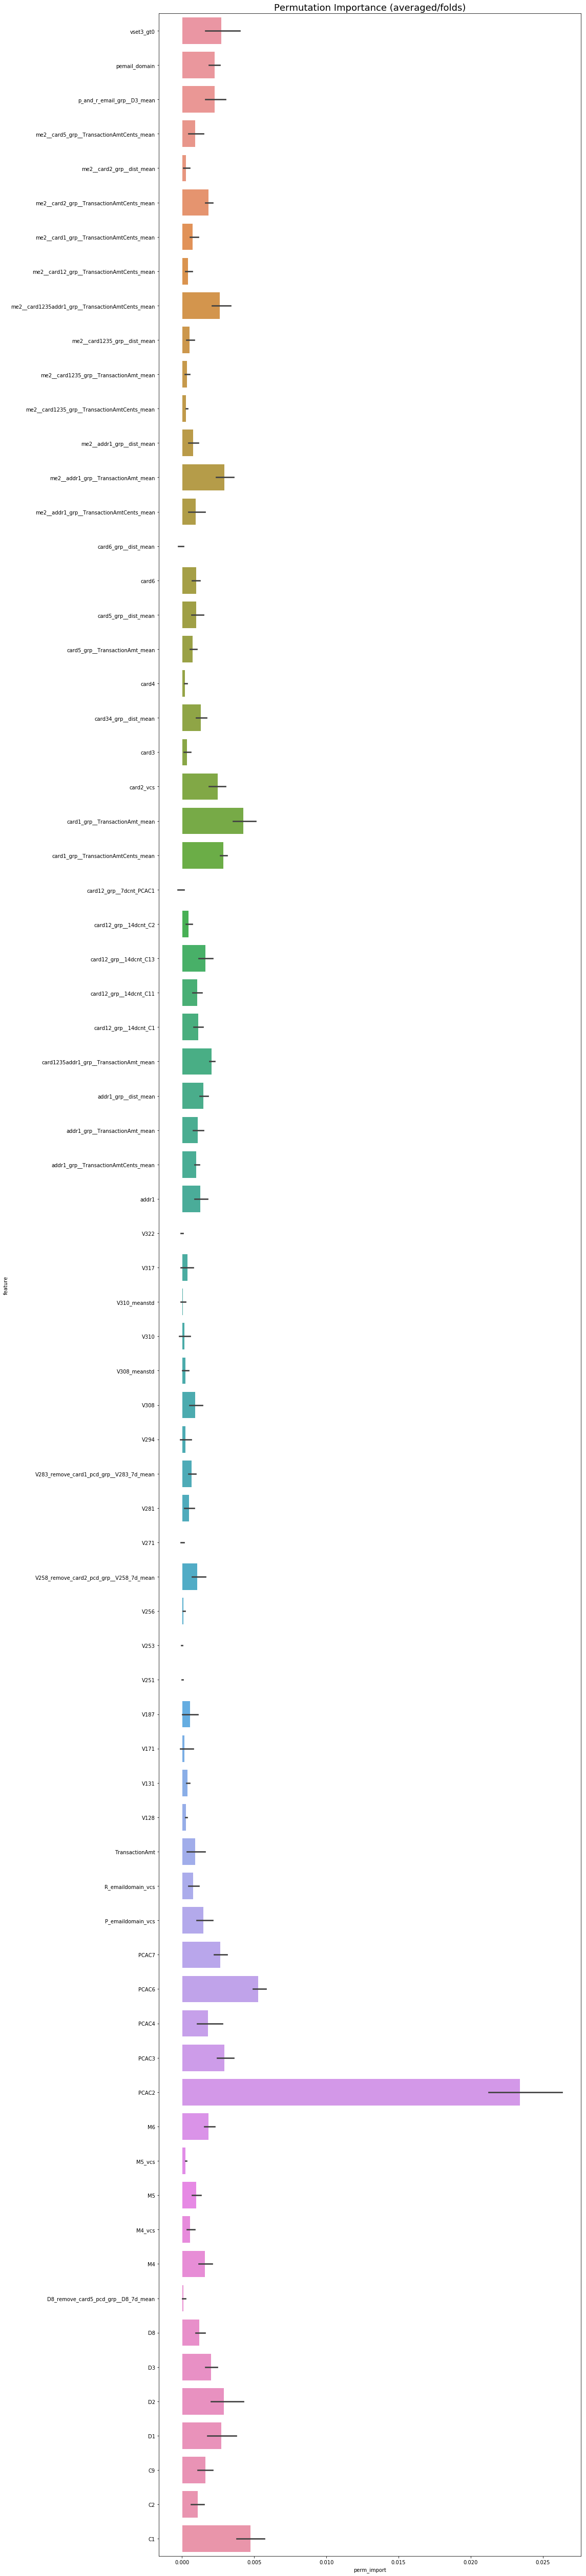

In [79]:
report, sns_features = display_report(results)

plt.figure(figsize=(16, 70))
sns.barplot(x="perm_import", y="feature", data=sns_features, edgecolor=('white'), linewidth=2)#, palette="rocket")
plt.title('Permutation Importance (averaged/folds)', fontsize=18)
plt.tight_layout()

report

In [ ]:
report.sort_values('feature').feature.values

If we were to look at regular gain or splits, the V columns would dominate the show. But here we accurately see they really aren't that important in the grand scheme of things. Notice how some of our variables have a very high CVS score, especially the high cardinality categorical variables, like `card2` for example. While the unique values present for card2 in train and test are very similar, their distributions shift a bit:

In [ ]:
report.sort_values('adversarial',ascending=False)

In [59]:
# report[
#     (report.adversarial<=0.04) &
#     (report.perm_import>0) &
#     (np.abs(report.perm_import_std/report.perm_import) < 0.75)
# ].sort_values('perm_import',ascending=False).feature.values

array(['PCAC2', 'PCAC3', 'PCAC6', 'C1', 'M6', 'pemail_domain',
       'card1235addr1_grp__TransactionAmt_mean',
       'p_and_r_email_grp__D3_mean', 'D2',
       'me2__addr1_grp__TransactionAmt_mean', 'addr1', 'M5',
       'me2__card1235addr1_grp__TransactionAmtCents_mean',
       'addr1_grp__dist_mean', 'card1_grp__TransactionAmt_mean', 'C2',
       'card2_vcs', 'me2__addr1_grp__TransactionAmtCents_mean',
       'addr1_grp__TransactionAmt_mean',
       'addr1_grp__TransactionAmtCents_mean', 'PCAC4', 'PCAC7', 'M4',
       'card12_grp__14dcnt_C13', 'card1_grp__TransactionAmtCents_mean',
       'card12_grp__14dcnt_C11',
       'me2__card2_grp__TransactionAmtCents_mean', 'card5_grp__dist_mean',
       'D1', 'P_emaildomain_vcs', 'V281', 'V294',
       'me2__card1_grp__TransactionAmtCents_mean', 'V317', 'V308',
       'me2__addr1_grp__dist_mean', 'C9', 'D8', 'V310',
       'me2__card12_grp__TransactionAmtCents_mean',
       'card6_grp__dist_mean', 'vset3_gt0', 'card12_grp__14dcnt_C1',
     

In [ ]:
# notfraud = data[data.isFraud==0]
# fraud = data[data.isFraud==1]
# nottrain = data[data.isFraud.isna()]

# for feature in features:
#     if feature=='C3': continue
#     plt.figure(figsize=(7,5))
#     plt.title(feature)
#     plt.scatter(notfraud.TransactionDT, notfraud[feature], s=1, alpha=0.1)
#     plt.scatter(fraud.TransactionDT, fraud[feature], s=1, alpha=0.4)
    
#     plt.scatter(nottrain.TransactionDT, nottrain[feature], s=1, alpha=0.4)
#     plt.show()

# Submission

Once we've decided on a subset of good engineered features to use, we must run the submission pipeline to submit. The submission pipeline is completely different from the feature validation pipeline. Rather, the sub pipeline builds many versions of a single model and merges them together. I wouldn't call this ensembling per se, since that'll happen is another, external script. But this is how we prepare our 'level-1' models for posting against Kaggle LB.

## VersionA

- Train on first 50% of Train data
- Validate on second 50% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Calculate `mean best rounds`
- Ideally, `STD / Mean` rounds should be relatively 'low'
- Train on second 50% of Train data using the `mean best rounds` calculated above without early stopping (no validation)
- Repeat above step 3x, with different random _model_ seeds
- Train on entire (100%) Train data using 2x rounds `mean best rounds` calculated above without early stopping (no validation)
- So we have:
    - A) 3 models (different seeds) trained on first 50% of train data, each with unique `best rounds`.
    - B) 3 models (different seeds) trained on second 50% of train data, each with the same `mean best rounds`
    - C) 3 models (different seeds) trained on 100% of train data, each with the same `mean best rounds * 2`
- Use each of these models to predict the submission set:
    - Take the mean val of A), the mean val of B), and the mean val of C)
- Try two merging strategies for final LB submission:
    - A^0.2 + B^0.2 + C^0.6, and validate LB
    - (A + B + C) / 3, and validate LB
- Use whichever of the last two strategies works best.

## VersionB

- Train on first 33% of Train data
- Validate on second 33% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Train on second 33% of Train data
- Validate on third 33% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Calculate `mean best rounds`
- Ideally, `STD / Mean` rounds should be relatively 'low'
- Train on third 33% of Train data using the `mean best rounds` calculated above without early stopping (no validation)
- Repeat above step 3x, with different random _model_ seeds
- Train on entire (100%) Train data using 3x rounds `mean best rounds` calculated above without early stopping (no validation)
- So we have:
    - A) 3 models (different seeds) trained on first 33% of train data, each with unique `best rounds`.
    - C) 3 models (different seeds) trained on second 33% of train data, each with unique `best rounds`.
    - B) 3 models (different seeds) trained on third 33% of train data, each with the same `mean best rounds`
    - C) 3 models (different seeds) trained on 100% of train data, each with the same `mean best rounds * 3`
- Use each of these models to predict the submission set:
    - Take the mean val of A), the mean val of B), the mean val of C), and the mean val of D)
- Try two merging strategies for final LB submission:
    - A^0.166 + B^0.166 + C^0.166 + D^0.6, and validate LB
    - (A + B + C + D) / 4, and validate LB
- Use whichever of the last two strategies works best.

## VersionC

- Train on first 75% of Train data
- Validate on second 25% of Train data
- Repeat above two steps 3x, with different random _model_ seeds
- Calculate `mean best rounds`
- Ideally, `STD / Mean` rounds should be relatively 'low'
- Train on remaining 25% of Train data using the `mean best rounds / 3` calculated above without early stopping (no validation)
- Repeat above step 3x, with different random _model_ seeds
- Train on entire (100%) Train data using 1.333x rounds `mean best rounds` calculated above without early stopping (no validation)
- So we have:
    - A) 3 models (different seeds) trained on first 75% of train data, each with unique `best rounds`.
    - B) 3 models (different seeds) trained on second 25% of train data, each with the same `mean best rounds / 3`
    - C) 3 models (different seeds) trained on 100% of train data, each with the same `mean best rounds * 1.333`
- Use each of these models to predict the submission set:
    - Take the mean val of A), the mean val of B), and the mean val of C)
- Try two merging strategies for final LB submission:
    - A^0.2 + B^0.2 + C^0.6, and validate LB
    - (A + B + C) / 3, and validate LB
- Use whichever of the last two strategies works best.

**NOTES**

1. Ideally, the best rounds for the 100% training across these versions should be the sameish.
1. Once we know if geometric or arithmetic mean works best, repeat the above process 5x times, each time using a different 20% (no replacement) non-fraud negative downsampling and straight average results.

In [104]:
def update_seeds(params, new_seed=1337):
    params['seed'] = new_seed
    params['feature_fraction_seed'] = new_seed + 3
    params['bagging_seed'] = new_seed + 5
    params['drop_seed'] = new_seed + 7
    params['data_random_seed'] = new_seed + 11
    return params

In [118]:
def build_model(data, features, params, mask_train=None, mask_val=None, num_rounds=None, cat_features='auto'):
    print('')
    if mask_train is None:
        trn = data
    else:
        trn = data[mask_train]
    trn_lgb = lgb.Dataset(trn[features], label=trn.isFraud)
    print('Trn Shape:', trn.shape[0], 'DTs:', trn.TransactionDT.iloc[0], trn.TransactionDT.iloc[-1])
    
    if mask_val is not None:
        val = data[mask_val]
        val_lgb = lgb.Dataset(val[features], label=val.isFraud)
        print('Val Shape:', val.shape[0], 'DTs:', val.TransactionDT.iloc[0], val.TransactionDT.iloc[-1])
        
        clf = lgb.train(
            params,
            trn_lgb,
            valid_sets = [trn_lgb, val_lgb],
            verbose_eval = 200,
            early_stopping_rounds = 33,
            num_boost_round = 80000,
            categorical_feature = cat_features
        )
        num_rounds = clf.best_iteration
        
    else:
        clf = lgb.train(
            params,
            trn_lgb,
            verbose_eval = 200,
            num_boost_round = num_rounds,
            categorical_feature = cat_features
        )
        num_rounds = None
        
    return clf, num_rounds

In [140]:
def prepare_base_submission(data, features, params, version='a', runs=1, seed=1337, cat_features='auto'):
    # Change runs to 3 for a proper (final) sub
    # Runs can be 1 for a 'faster' sub
    version = version.lower()
    params = params.copy() # dont mess up the original
    train = data[~data.isFraud.isna()]
    sub_data = data[data.isFraud.isna()]
    print('Training Version:', version, 'with', runs, 'runs.')
    
    folder = './' + str(datetime.datetime.now()).replace('-','').replace(':','').split('.')[0].replace(' ','_') + '_v'+version
    !mkdir {folder}
    
    # Save our info
    with open(folder + '/info.txt', 'a') as handle:
        handle.write('Training Version: {} with {} runs.'.format(version, runs))
        handle.write('Params:\n' + json.dumps(params, ensure_ascii=False, indent=4))
        handle.write('\n\nFeatures: ' + ', '.join(features))
    
    if version=='a':
        ########################################################################
        # Train on first 50% of Train data
        # Validate on second 50% of Train data
        # Repeat above two steps 3x, with different random model seeds
        splitPoint = train.TransactionDT.min() + (train.TransactionDT.max() - train.TransactionDT.min()) / 2
        splitA = train.TransactionDT<=splitPoint
        splitB = train.TransactionDT> splitPoint
        
        roundsA = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitA,
                mask_val = splitB,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsA.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('Run {}: Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splita_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splita_run{}.csv'.format(run+1), index=False)
            
            
            
        # Calculate mean best rounds
        # Ideally, STD / Mean rounds should be relatively 'low'
        roundsA = np.array(roundsA)
        mean_roundsA = int(roundsA.mean())
        std_roundsA = roundsA.std()
        print('{:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsA, std_roundsA))
        if std_roundsA/mean_roundsA > 0.333: print('NOTE: std/mean is pretty high here...')
            
        # Train on second 50% of Train data using the mean best rounds calculated above without early stopping (no validation)
        # Repeat above step 3x, with different random model seeds
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitB,
                num_rounds = mean_roundsA,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitb_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitb_run{}.csv'.format(run+1), index=False)
            
        # Train on entire (100%) Train data using 2x rounds mean best rounds calculated above without early stopping (no validation)
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                num_rounds = mean_roundsA * 2,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitc_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitc_run{}.csv'.format(run+1), index=False)
            
            
        # So we have:
        # A) `runs` models (different seeds) trained on first 50% of train data, each with unique best rounds.
        # B) `runs` models (different seeds) trained on second 50% of train data, each with the same mean best rounds
        # C) `runs` models (different seeds) trained on 100% of train data, each with the same mean best rounds * 2
        # Use each of these models to predict the submission set (already done)
        
        # Take the mean val of A), the mean val of B), and the mean val of C)
        for split in 'abc':
            preds = np.concatenate([
                pd.read_csv(folder + '/split{}_run{}.csv'.format(split,run+1)).isFraud.values.reshape(-1,1)
                for run in range(runs)
            ], axis=1).mean(axis=1)
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': preds.flatten()
            }).to_csv(folder + '/split{}_mean.csv'.format(split), index=False)
        

        # Try two merging strategies for final LB submission:
        # Use whichever of the last two strategies works best.
        splits = [
            pd.read_csv(folder + '/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abc'
        ]
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0]**0.2 + splits[1]**0.2 + splits[2]**0.6).flatten()
        }).to_csv(folder + '/sub_geometric_mean.csv', index=False)
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2]).flatten() # No need to even /3 since AUC
        }).to_csv(folder + '/sub_arithmetic_mean.csv', index=False)
        
        
        
    
    elif version=='b':
        ########################################################################
        # Train on first 33% of Train data
        # Validate on second 33% of Train data
        # Repeat above two steps 3x, with different random model seeds
        splitPoint1 = train.TransactionDT.min() + (train.TransactionDT.max() - train.TransactionDT.min()) / 3
        splitPoint2 = train.TransactionDT.min() + (train.TransactionDT.max() - train.TransactionDT.min()) / 3 * 2
        splitA = train.TransactionDT<=splitPoint1
        splitB = (train.TransactionDT>splitPoint1) & (train.TransactionDT<=splitPoint2)
        splitC = train.TransactionDT>splitPoint2
        
        roundsA = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitA,
                mask_val = splitB,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsA.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('RunA {}: Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splita_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splita_run{}.csv'.format(run+1), index=False)
          
        
        # Train on second 33% of Train data
        # Validate on third 33% of Train data
        # Repeat above two steps 3x, with different random model seeds
        roundsB = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitB,
                mask_val = splitC,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsB.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('RunB {}: Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splitb_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitb_run{}.csv'.format(run+1), index=False)
            
            
            
        # Calculate mean best rounds
        # Ideally, STD / Mean rounds should be relatively 'low'
        roundsA = np.array(roundsA)
        roundsB = np.array(roundsB)
        mean_roundsA = int(roundsA.mean())
        mean_roundsB = int(roundsB.mean())
        std_roundsA = roundsA.std()
        std_roundsB = roundsB.std()
        print('A) {:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsA, std_roundsA))
        print('B) {:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsB, std_roundsB))
        rounds = np.array(roundsA + roundsB)
        mean_rounds = int(rounds.mean())
        std_rounds = rounds.std()
        if std_roundsA/mean_roundsA > 0.333: print('NOTE: A) std/mean is pretty high here...')
        if std_roundsB/mean_roundsB > 0.333: print('NOTE: B) std/mean is pretty high here...')
        if std_rounds/mean_rounds > 0.333: print('NOTE: *) std/mean is pretty high here...')
        
        
        # Train on third 33% of Train data using the mean best rounds calculated above without early stopping (no validation)
        # Repeat above step 3x, with different random model seeds
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitC,
                num_rounds = mean_rounds,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitc_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitc_run{}.csv'.format(run+1), index=False)
            
        # Train on entire (100%) Train data using 3x rounds mean best rounds calculated above without early stopping (no validation)
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                num_rounds = mean_rounds * 3,
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitd_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitd_run{}.csv'.format(run+1), index=False)
            
            
        # So we have:
        # A) 3 models (different seeds) trained on first 33% of train data, each with unique best rounds.
        # C) 3 models (different seeds) trained on second 33% of train data, each with unique best rounds.
        # B) 3 models (different seeds) trained on third 33% of train data, each with the same mean best rounds
        # C) 3 models (different seeds) trained on 100% of train data, each with the same mean best rounds * 3
        # Use each of these models to predict the submission set (already done)
        
        # Take the mean val of A), the mean val of B), the mean val of C), and the mean val of D)
        for split in 'abcd':
            preds = np.concatenate([
                pd.read_csv(folder + '/split{}_run{}.csv'.format(split,run+1)).isFraud.values.reshape(-1,1)
                for run in range(runs)
            ], axis=1).mean(axis=1)
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': preds.flatten()
            }).to_csv(folder + '/split{}_mean.csv'.format(split), index=False)
        

        # Try two merging strategies for final LB submission:
        # Use whichever of the last two strategies works best.
        splits = [
            pd.read_csv(folder + '/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abcd'
        ]
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0]**0.1666 + splits[1]**0.1666 + splits[2]**0.1666 + splits[3]**0.4).flatten()
        }).to_csv(folder + '/sub_geometric_mean.csv', index=False)
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2] + splits[3]).flatten() # No need to even /4 since AUC
        }).to_csv(folder + '/sub_arithmetic_mean.csv', index=False)
        
        
        
    
    
    else:
        ########################################################################
        # Train on first 75% of Train data
        # Validate on second 25% of Train data
        # Repeat above two steps 3x, with different random model seeds
        splitPoint = train.TransactionDT.min() + (train.TransactionDT.max() - train.TransactionDT.min()) / 4 * 3
        splitA = train.TransactionDT<=splitPoint
        splitB = train.TransactionDT> splitPoint
        
        roundsA = []
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitA,
                mask_val = splitB,
                num_rounds = None, # let it compute
                cat_features = cat_features
            )
            roundsA.append(num_rounds)
            with open(folder + '/info.txt', 'a') as handle:
                handle.write('Run {}: Num Rounds: {}, {} AUC\n'.format(run+1, num_rounds, clf.best_score['valid_1']['auc']))
                
            # Save the model
            clf.save_model(folder + '/splita_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splita_run{}.csv'.format(run+1), index=False)
            
            
            
        # Calculate mean best rounds
        # Ideally, STD / Mean rounds should be relatively 'low'
        roundsA = np.array(roundsA)
        mean_roundsA = int(roundsA.mean())
        std_roundsA = roundsA.std()
        print('{:.0f} mean best rounds, with {:.3f} STD'.format(mean_roundsA, std_roundsA))
        if std_roundsA/mean_roundsA > 0.333: print('NOTE: std/mean is pretty high here...')
            
        # Train on second 25% of Train data using the mean best rounds / 3 calculated above without early stopping (no validation)
        # Repeat above step 3x, with different random model seeds
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                mask_train = splitB,
                num_rounds = int(mean_roundsA/3),
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitb_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitb_run{}.csv'.format(run+1), index=False)
            
        # Train on entire (100%) Train data using 2x rounds mean best rounds calculated above without early stopping (no validation)
        for run in range(runs):
            params = update_seeds(params, new_seed=seed+run)
            clf, num_rounds = build_model(
                train,
                features,
                params,
                num_rounds = int(mean_roundsA * 1.3333),
                cat_features = cat_features
            )
        
            # Save the model
            clf.save_model(folder + '/splitc_run{}.lgb'.format(run+1))
            
            # Save submission preds
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': clf.predict(sub_data[features]).flatten(),
            }).to_csv(folder + '/splitc_run{}.csv'.format(run+1), index=False)
            
            
        # So we have:
        # A) 3 models (different seeds) trained on first 75% of train data, each with unique best rounds.
        # B) 3 models (different seeds) trained on second 25% of train data, each with the same mean best rounds / 3
        # C) 3 models (different seeds) trained on 100% of train data, each with the same mean best rounds * 1.3333
        # Use each of these models to predict the submission set (already done)
        
        # Take the mean val of A), the mean val of B), and the mean val of C)
        for split in 'abc':
            preds = np.concatenate([
                pd.read_csv(folder + '/split{}_run{}.csv'.format(split,run+1)).isFraud.values.reshape(-1,1)
                for run in range(runs)
            ], axis=1).mean(axis=1)
            pd.DataFrame({
                'TransactionID': sub_data.TransactionID,
                'isFraud': preds.flatten()
            }).to_csv(folder + '/split{}_mean.csv'.format(split), index=False)
        

        # Try two merging strategies for final LB submission:
        # Use whichever of the last two strategies works best.
        splits = [
            pd.read_csv(folder + '/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abc'
        ]
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0]**0.2 + splits[1]**0.2 + splits[2]**0.6).flatten()
        }).to_csv(folder + '/sub_geometric_mean.csv', index=False)
        pd.DataFrame({
            'TransactionID': sub_data.TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2]).flatten() # No need to even /3 since AUC
        }).to_csv(folder + '/sub_arithmetic_mean.csv', index=False)
    
    
    return folder

In [147]:
        splits = [
            pd.read_csv('20190920_181843_vb/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
            for split in 'abcd'
        ]

        pd.DataFrame({
            'TransactionID': data[data.isFraud.isna()].TransactionID,
            'isFraud': (splits[0] + splits[1] + splits[2] + splits[3]).flatten() # No need to even /4 since AUC
        }).to_csv( '20190920_181843_vb/sub_arithmetic_mean.csv', index=False)
        

In [142]:
prepare_base_submission(
    data,
    features,
    lgb_params,
    version='b',
    runs=3,
    seed=1337,
    cat_features='auto'
)

Training Version: b with 3 runs.

Trn Shape: 225170 DTs: 86400 5327956
Val Shape: 193062 DTs: 5328003 10569489
Training until validation scores don't improve for 33 rounds.
[200]	training's auc: 0.914833	valid_1's auc: 0.885353
[400]	training's auc: 0.940408	valid_1's auc: 0.898244
[600]	training's auc: 0.956642	valid_1's auc: 0.904283
[800]	training's auc: 0.967232	valid_1's auc: 0.907398
[1000]	training's auc: 0.974336	valid_1's auc: 0.909015
[1200]	training's auc: 0.979714	valid_1's auc: 0.909962
[1400]	training's auc: 0.983619	valid_1's auc: 0.910706
[1600]	training's auc: 0.986852	valid_1's auc: 0.91133
Early stopping, best iteration is:
[1699]	training's auc: 0.988253	valid_1's auc: 0.911553

Trn Shape: 225170 DTs: 86400 5327956
Val Shape: 193062 DTs: 5328003 10569489
Training until validation scores don't improve for 33 rounds.
[200]	training's auc: 0.914997	valid_1's auc: 0.885767
[400]	training's auc: 0.940383	valid_1's auc: 0.898484
[600]	training's auc: 0.956114	valid_1's au

IndexError: string index out of range

In [ ]:
# Check correlation among folds

In [129]:
gc.collect()
splits = [
    pd.read_csv( '20190920_165259_vc/split{}_mean.csv'.format(split)).isFraud.values.reshape(-1,1)
    for split in 'abc'
]
c = pd.DataFrame({
    'a':splits[0].flatten(),
    'b':splits[1].flatten(),
    'c':splits[2].flatten(),
})
c.corr()

In [ ]:
# TODO (1-time only):
# Run version a locally with runs=3
# Look at correlation of scores for splita, splitb, and splitc. if they're close, perhaps geomean is useful here.
# Check on Val and LB which is better, geomean or arimean
# Comment out the code for the one that is worse.

# TODO (1-time only())
# Run version a, b, and c locally with runs=3
# Compare a) numrounds*2, b) numrounds*3, c) numrounds*1.333
# Hopefully the values aren't too different
# Check on Val and LB of each version, which is better
# Only use that version going forward

# TODO (each LB submission)
# Use np.random.choice w replace=False to chop up train[traintr.isFraud==0] into 20% chunks
# For each 20% chunk of isFraud=0
# - Merge the 20% isFraud=0 with 100% isFraud=1
# - Run the best 'version' locally with runs=3 and whatever is better geo-mean, or arith-mean
# - Check on Val values of each chunk
# Take the mean of all 5 chunk predictions
# Submit for LB score

# TODO: do the above but also consider negatie subsampling

In [ ]:
# # TODO: Complete this code:
# def final_sub(data, seed=1337):
#     np.random.seed(seed)
#     normies = data[data.isFraud==0].index.values
#     count = int(data.shape[0]*downsample_frac)
    
#     picked = []
#     for _ in range(5):
#         pick = np.random.choice(
#             [normies], # todo remove from picked
#             count,
#             replace=False
#         )
        
#         selection = data[data.index.isin(
#             # All fruds and a number of normies
#             np.concatenate([normies, data[data.isFraud==1].index.values])
#         )].copy()

# EDA (Hereafter)

In [ ]:
# In order of importance:
for col in ['C13','C1','C6']:
    plt.figure(figsize=(14,10))
    plt.title(col)
    plt.scatter(traintr[traintr.isFraud==0].TransactionDT, traintr[traintr.isFraud==0][col], s=1, alpha=0.1)
    plt.scatter(traintr[traintr.isFraud==1].TransactionDT, traintr[traintr.isFraud==1][col], s=1, alpha=0.4)
    plt.show()

In [ ]:
for col in ['C'+str(c) for c in range(1,15)]:
    plt.figure(figsize=(7,5))
    plt.title(col)
    plt.scatter(traintr[traintr.isFraud==0].TransactionDT, traintr[traintr.isFraud==0][col], s=1, alpha=0.1)
    plt.scatter(traintr[traintr.isFraud==1].TransactionDT, traintr[traintr.isFraud==1][col], s=1, alpha=0.4)
    plt.show()

TODO: 
    Combine a few C's by sum or by PCA.

In [ ]:
big set: 1,2,4,6,7,8,10,11,12,13,14
weaker subset: 10,8,4
weaker subset: 12,7
weird subset: 5,9

In [ ]:
# Weaker Set:
for col in ['C'+str(c) for c in [4,8,10]]:
    plt.figure(figsize=(7,5))
    plt.title(col)
    plt.scatter(traintr[traintr.isFraud==0].TransactionDT, traintr[traintr.isFraud==0][col], s=1, alpha=0.1)
    plt.scatter(traintr[traintr.isFraud==1].TransactionDT, traintr[traintr.isFraud==1][col], s=1, alpha=0.4)
    plt.show()

In [ ]:
# INVESTIGATE!!!! 0 NANS IN TRAIN:
data[['C'+str(c) for c in [1,2,6,7,11,12,13,14]]].isna().sum()

In [ ]:
# 1,2,6,7,11,12,13,14



In [ ]:
dataC = pca.fit_transform(data[['C'+str(c) for c in [1,2,6,7,11,12,13,14]]].fillna(0))
for i in range(8): data['PCAC'+str(i+1)] = dataC[:,i].flatten()

for i in range(8):
    z = dataC[:traintr.shape[0],i]
    plt.figure(figsize=(7,5))
    plt.scatter(traintr[traintr.isFraud==0].TransactionDT, z[traintr.isFraud==0], s=1, alpha=0.1)
    plt.scatter(traintr[traintr.isFraud==1].TransactionDT, z[traintr.isFraud==1], s=1, alpha=0.4)
    
    z = dataC[traintr.shape[0]:,i]
    plt.scatter(testtr.TransactionDT, z, s=1, alpha=0.4)
    plt.show()
    
del dataC

In [ ]:
data[['card1','card2','card3','card4','card5','card6']].nunique()

In [ ]:
data['cardid_4'] = stringy(data.card1) + stringy(data.card2) + stringy(data.card3) + stringy(data.card4)

In [ ]:
# Calculate isFraud.mean by value count appearance (keep in mind test set...)
# Calculate where the fraud occurs for cards uses 2-10 times...
look = data[~data.isFraud.isna()].groupby('cardid_4').size().reset_index()
look.rename(columns={0:'cnt'},inplace=True)
look = look[look.cnt.between(2,10)]
df = data[~data.isFraud.isna()].groupby('cardid_4').isFraud.agg(['mean','size']).reset_index()
look = look.merge(df, how='left', on='cardid_4')
look

In [ ]:
# pca2 or 3 diff per card
data[data.cardid_4==look[look['mean']>0].cardid_4.values[19]]

In [ ]:
todo
mean cnts and me cnts by cardid + productcd, as well as time.

when we have a fraud on a card, how soon do we have a non-fraud?
is that a function of number of transactions on the card?
